# 

# Welcome to dymoval's tutorial!
 
In this tutorial we show the main functionalities of *dymoval*. In particular, we will show:

- How to clean up a measurement dataset,
- How to use such a dataset for validating a model. 

## DC Motor model
We assume that we developed the model of a DC electric motor which is connected to a constant load and 
it is now time for the truth: can we trust our simulation results?

To figure it out, we need to validate it, and *dymoval* is all about that.

But how does our model look like? 
We modeled the interaction between DC voltage, considered as *input*, and the motor speed and the DC current, considered as *outputs*, as shown in the following picture:

<p align="center">
    <br>
  <img src="./DCMotor.svg" width="750" title="DCMotor" class="center">
</p>

### Validation setup
Our model lies in our laptop, but in order to validate it, we need to run some experiments on the actual DC motor and log the measured data.

We ask a team of engineers to run some experiments in the lab and to log the measurements in a log file, possibly in `HDF5` format. 
In particular, we ask to log the supply voltage, and the measured armature current and the motor speed, which represent our model inputs and outputs.
They made us happy and provided us with the logs in a `HDF5` file. 

## Log data clean-up
The first step now is to extract the measurements data from the `HDF5` and take a look at them. For achieving such a goal, we import some typical packages that suit our need:

In [1]:
%matplotlib inline
from IPython.display import display
import matplotlib.pylab as plt
import h5py
from copy import deepcopy
import numpy as np
import pandas as pd
import dymoval as dmv
import matplotlib

# This is our model
from dymoval_tutorial.DCMotorModel import (
    DCMotor_model_dt,
)
import control as ct

# set max number of displayed decimals
np.set_printoptions(precision=4, suppress=True)
pd.options.display.float_format = lambda x: f"{x:.4f}"

Next, let's read the log data stored in the `HDF5` file. All the logs that we are interested in are stored in the group "*signals*".
Feel free to explore the hdf5 file at your convenience.
We use the `h5py` package to read it, but feel free to explore any other package that can read HDF5 files.

In [2]:
measurements_file = "./DCMotor_measurements.h5"
logs = h5py.File(measurements_file, "r")

We extract the logged signals as it follows (see *h5py* docs for more info):

In [3]:
V = logs["signals/V_measured"]  # Measured supply voltage (input)
Ia = logs["signals/Ia_measured"]  # Measured current (output)
motor_speed = logs["signals/motor_speed_measured"]  # Measured motor rotational speed (output)

To begin with, we map the measured values into *dymoval* `Signals`. 
Dymoval's `Signals` are  Python `dict` (in reality they are `Typeddict`) with the following keys:

- `name`,
- `samples`,
- `signal_unit`,
- `sampling_period` and
- `time_unit`

which are  quantities that typically chracterize a physical signal. 

Let's map the logs into Dymoval Signals: 

In [4]:
signal_list = []
for val in [V, Ia, motor_speed]:
    temp: dmv.Signal = {
        "name": val.attrs["name"],
        "samples": val[:],
        "signal_unit": val.attrs["unit"],
        "sampling_period": val.attrs["period"],
        "time_unit": val.attrs["sampling_unit"],
    }
    signal_list.append(deepcopy(temp))

logs.close()

Let's see how these measurements look like:

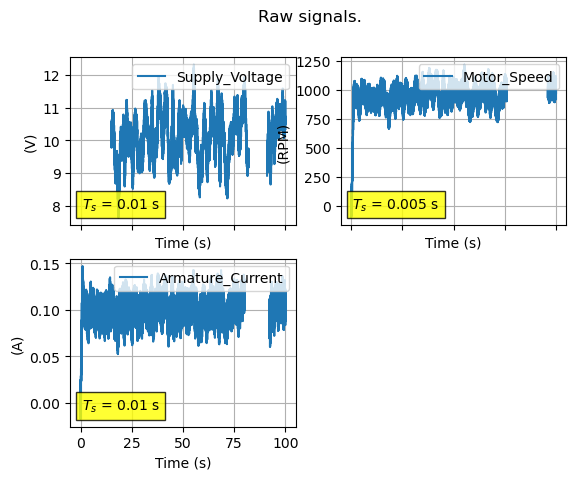

In [5]:
fig = dmv.plot_signals(*signal_list)
display(fig)

The first thing we notice is that the signals have not been logged with the same sampling period and there is also some missing data. And to really not miss anything, the measurements also look noisy.

Well, things happen in the lab! And to make things even worst, it does not seem possible to run more experiments before the next month.

We better off to clean these logs. A good measurements dataset should have all the signals sampled with the same sampling period, it should not contains missing data and the signal-to-noise ratio should be sufficiently high.

Firstly, we see that in the interval about $T = [40,70]\,s$ all the signals have no missing data. We can take that portion to validate our model.
However, the signals have been sampled with different sampling periods. 

Fortunately, *dymoval* allows us to trim signals and to re-sample them (and eventually fix missing data, if needed) and to store the results in a `Dataset` object.
Lst's do that and let's separate signals in inputs and outputs:

In [6]:
signal_names = [s["name"] for s in signal_list]
u_names = signal_names[0]
y_names = signal_names[1:]

ds = dmv.Dataset(
    "DCMotor",
    signal_list,
    u_names,
    y_names,
    target_sampling_period=0.01,
    tin=40,
    tout=70.0,
)

When creating a dymova *Dataset* object, the signals are always re-sampled in such a way that all of them will have the same sampling period, but sometimes this is not possible and therefore some signals may be excluded from the Dataset. 

The list of the excluded signals are stored in the attibute `excluded_signal`.

In [7]:
ds.excluded_signals

[]

In our case, we have been lucky because it was possible to re-sample all the signals.

Let's now take a look at our cleaned Dataset:

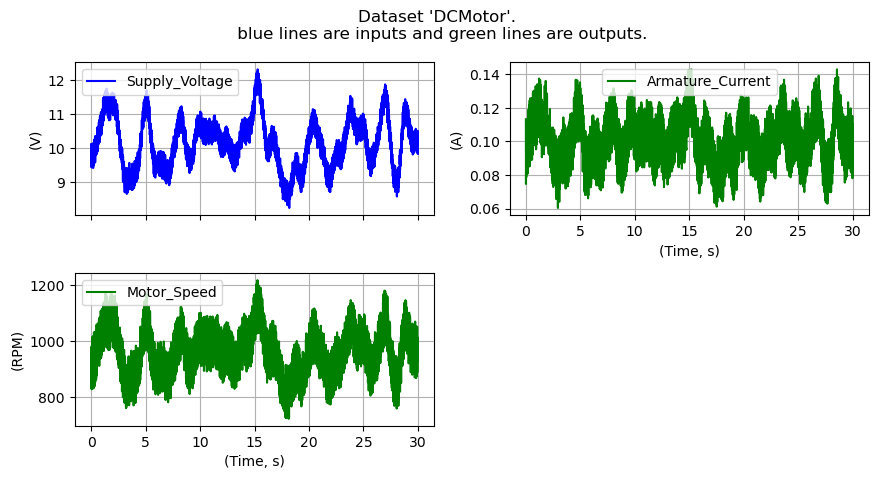

In [8]:
fig = ds.plot()
display(fig)

The datset is not bad, but the measurements are a bit noisy. Let's clean them up a little bit through a low pass filter. But wait! How to choose the cutoff frequency?

Well, we can perform a spectral analysis.
We plot the spectrum through the method `plot_spectrum()` but before we remove the continuous component through the `remove_means()` method given that the signals have a fairly large continuous component:

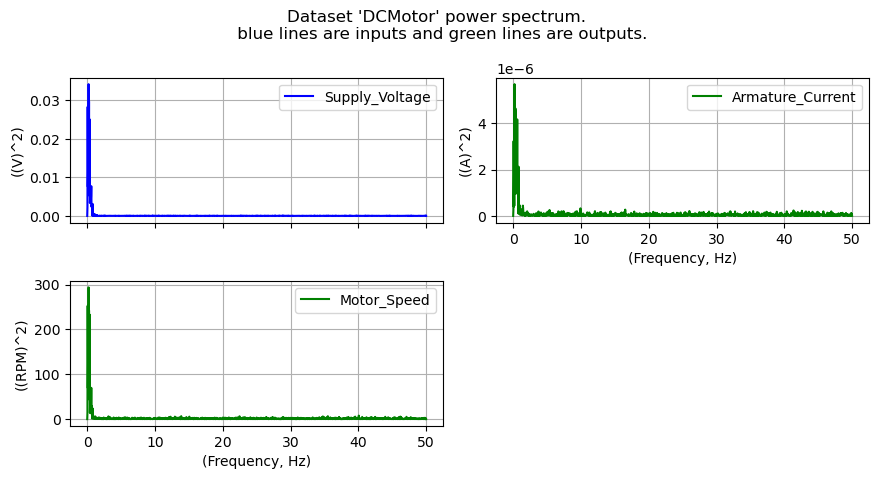

In [9]:
fig = ds.remove_means().plot_spectrum()
display(fig)

The signals bandwidth of two over three signals is in contained very a narrow range of about $f < 2\, Hz$.

To avoid losing transient information and worsening the residuals analysis that we will do later on, we stay a bit larger than $2\, Hz$. We choose a cutoff frequency $f_c = 5\, Hz$.

In [10]:
cutoff = 5  # [Hz]
ds_filt = ds.low_pass_filter(
    ("Supply_Voltage", cutoff),
    ("Motor_Speed", cutoff),
    ("Armature_Current", cutoff),
)
ds_filt.name = "Filtered"

As you see from the function call, you could use different cutoff frequencies for each signal.

Let's take a look at the low-pass-filtered measurements:

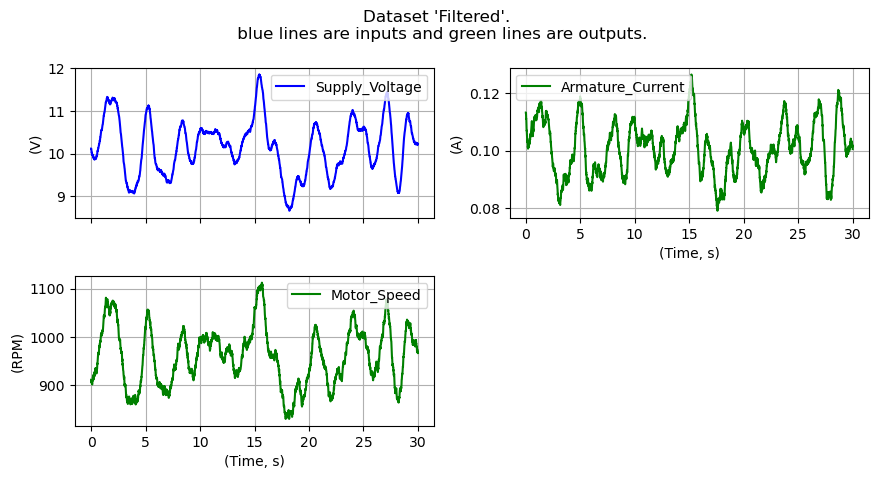

In [11]:
fig = ds_filt.plot()
display(fig)

...and let's compare our datasets before and after the filtering:

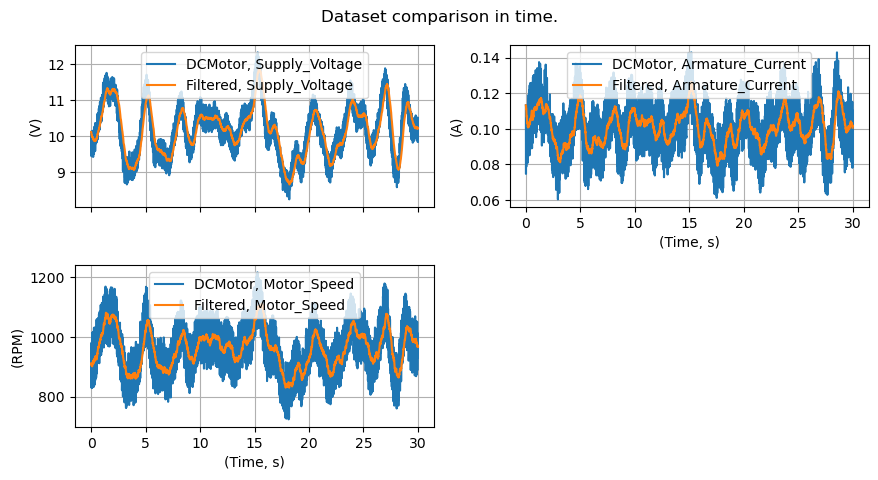

In [12]:
fig = dmv.compare_datasets(ds,ds_filt)
display(fig)

The chosen cutoff frequency seems to clean up most of the noise and at the same time it does not intoduce too much lag.

Let's see if we cut too much signal from the spectrum plot:

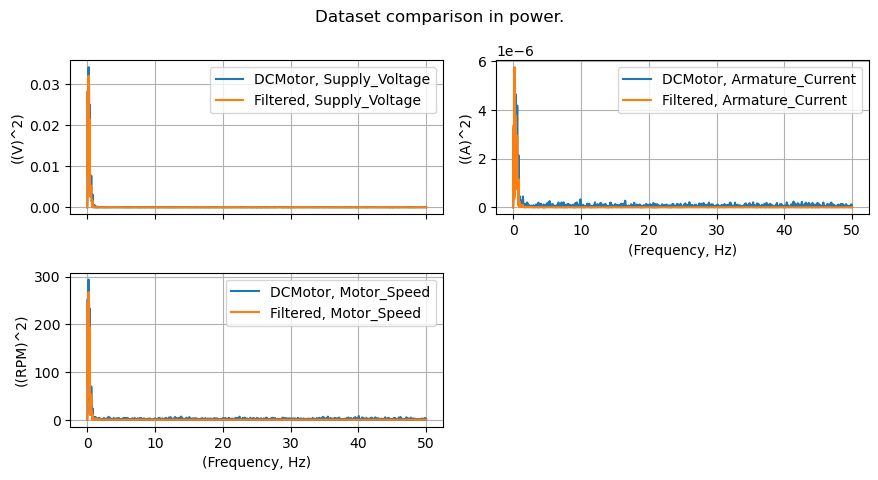

In [13]:
fig = dmv.compare_datasets(ds.remove_means(),ds_filt.remove_means(), kind='power')
display(fig)

It looks like that we just cut the noise, but most of the signal is still there.

Next, let's check the coverage of our filtered dataset.

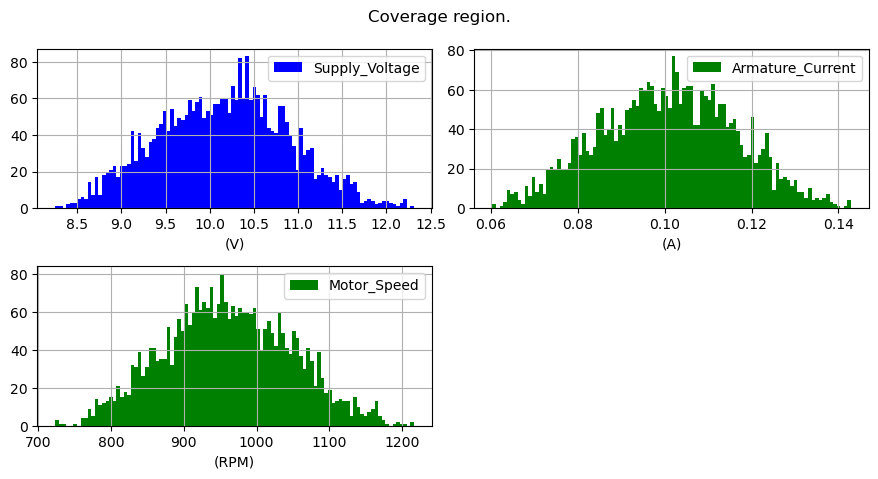

In [14]:
fig = ds.plot_coverage()
display(fig)

Knowing the coverage is extremely important and it shall always be stated when a model is delivered. The coverage region tell you the region where you can trust your model, simply because... well, you are going to validate your model in such a region. 

Next, only for the sake of showing more Dymoval features, we can selectively choose the signals that we want to plot or we can overlap them if we pass them as a tuple:

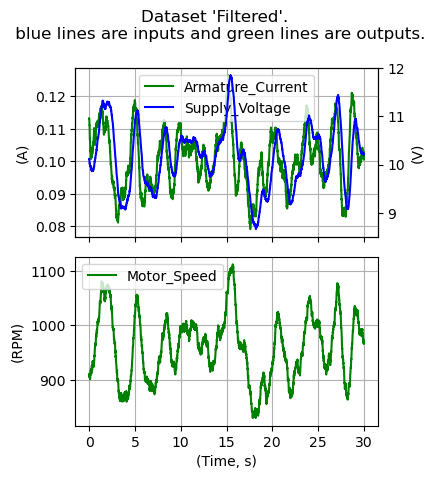

In [15]:
fig = ds_filt.plot(("Armature_Current", "Supply_Voltage"),"Motor_Speed")
display(fig)

## Validation Session

Here is what it is our table so far:

- cleaned-up measurements stored in a dymoval *Dataset* object,
- DC motor model.

It is now time for validation! 

The validation consists in comparing the *measured out* (cleaned and stored in out *Dataset* object `ds_filt`) with the *simulated outputs* from our model (to be obtained) when it is stimulated with the *measured input*.

Therefore, let's extracted the input `u` from the measurements `Dataset` and let's feed our model with it: 

In [16]:
(t, u, y) = ds_filt.dataset_values()

# Generated simulated out
res_sim = ct.forced_response(DCMotor_model_dt, X0=[0.0, 0.0, 0.0], U=u)
y_sim = res_sim.y.T

To validate our we use the `validate_models()` function. Such a function takes measured in/out data along with the simulated out, and it return a `ValidationSession` object that contains all the information about the validation outcomes.

The measured in/out can be passed either as a `np.ndarray` or as a list of dymoval `Signal`. We opt for the latter option. However, the simulated outputs are passed as `np.ndarray`:

In [17]:
measured_signals = ds_filt.dump_to_signals()
measured_in = measured_signals["INPUT"]
measured_out = measured_signals["OUTPUT"]
sampling_period = measured_in[0]["sampling_period"]

vs = dmv.validation.validate_models(
    measured_in=measured_in,
    measured_out=measured_out,
    simulated_out=y_sim,
    sampling_period=0.01,
    U_bandwidths=cutoff,
    Y_bandwidths=[cutoff, cutoff],
)
vs

Validation session name: quick & dirty

Validation setup:
----------------
Inputs auto-correlation
Statistic: abs_mean-max
local weights: None
global weights: None
num lags: 41

Residuals auto-correlation:
Statistic: abs_mean-max
local weights: None
global weights: None
num lags: 41

Input-residuals cross-correlation:
Statistic: abs_mean-max
local weights: None
global weights: None
num lags: 41

Validation results:
-------------------
Thresholds: 
Input whiteness (abs_mean-max): 0.6 
R-Squared (%): 35.0000 
Residuals whiteness (abs_mean-max): 0.5000 
Input-Res whiteness (abs_mean-max): 0.5000 
Actuals:
                                        Sim_0
Input whiteness (abs_mean-max)         0.3532
R-Squared (%)                      -2570.2433
Residuals whiteness (abs_mean-max)     0.0187
Input-Res whiteness (abs_mean-max)     0.0403

         Sim_0  
Outcome: FAIL   

As we can see, our model failed the test. In particular, the value or the R-squared index is very bad. Let's take a look at the simulated VS measured out plot.

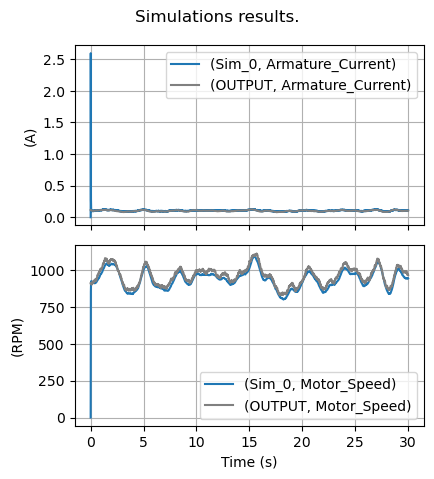

In [18]:
fig = vs.plot_simulations(dataset='out') 
display(fig)

As you can see, there is a large mismatch around `t = 0` between the measured and the simulated out, and that may be the reason of such a poor r-squared value. 

Such a mismatch is due to that around `t=0` the real DC Motor was in steady state, whereas our model started at initial condition `[0.0, 0.0 ,0.0]`, and therefore we were comparing "apples with oranges" in such a region. To fix this, either we adjust the initial condition of our model to match the measurement data, or we just neglect that area in the validation. We go for the latter solution by trimming the `ValidationSession` time span.

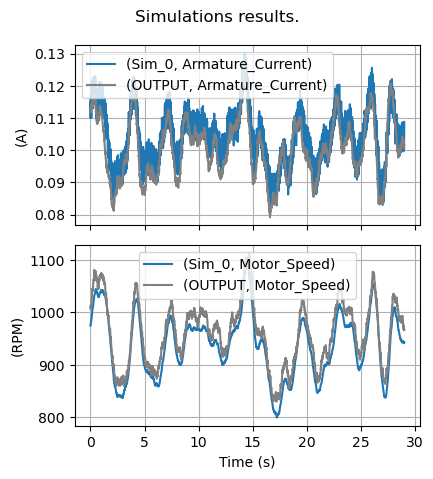

In [19]:
vs_trimmed = vs.trim(1, 30)
fig = vs_trimmed.plot_simulations(dataset='out')
display(fig)

The plots look much better. Let's take a look at the validation outcome:

In [20]:
vs_trimmed

Validation session name: quick & dirty

Validation setup:
----------------
Inputs auto-correlation
Statistic: abs_mean-max
local weights: None
global weights: None
num lags: 41

Residuals auto-correlation:
Statistic: abs_mean-max
local weights: None
global weights: None
num lags: 41

Input-residuals cross-correlation:
Statistic: abs_mean-max
local weights: None
global weights: None
num lags: 41

Validation results:
-------------------
Thresholds: 
Input whiteness (abs_mean-max): 0.6 
R-Squared (%): 35.0000 
Residuals whiteness (abs_mean-max): 0.5000 
Input-Res whiteness (abs_mean-max): 0.5000 
Actuals:
                                     Sim_0
Input whiteness (abs_mean-max)      0.3532
R-Squared (%)                      65.9009
Residuals whiteness (abs_mean-max)  0.1087
Input-Res whiteness (abs_mean-max)  0.2053

         Sim_0  
Outcome: PASS   

Our model passed the test!

The conclusion is that our model is **thrustworthy** as long as we use it **in the coverage region** that we showed before. 

However, if we look at what we have done, we realize that there is room for improving our validation procedure. In-fact, the measurements have been low-pass filtered and the the model has been fed with a low-pass filtered input. However, the simulated outputs have not been low-pass filtered. This means that we compared low-pass filtered outputs measurements with non-low-pass filtered simulation outputs! However, the validation result are good anyway and we can survive with that.

Typically, when you are evaluating models, you run batch of simulations with different models settings and you compare the results. Dymoval helps you in handling such a use case because you can pass `measured_out` argument as a list of simulation results, or you can use the method `append_simulation` of `ValidationSession` objects. See docs for more info. 

## How to interpret the results?

As a general rule, we want the R-squared index as large as possible, and all the whiteness indices as small as possible. 

The R-squared index tell us how the simulation results fit the measurements data, whereas the residuals give us information about about the dynamic behavior of our model. 
More precisesly:

- If the input signal has low whiteness value (i.e. as close as to 0.0), then more it means that during the lab tests the guys "hit all the corners" of real motor, i.e. the *system has been adequately stimulated* and that gives a higher trust to our model if the validation metrics are good.
- If the residuals whiteness is large, then there are some dynamics that have been poorly modeled, and therefore the model needs some updated. In this case, if the R-squared is large, it only means that your model is fitting well what has been modeled, but yet there are many things not modeled!
- If the input-residuals whiteness level is large, it means that the input-output model needs improvements.

For simulation models, which motivated dymoval development, we are interested in the dynamic behavior of models more than the point-wise fit of the data. Hence, even if the R-squared index is low, the model can still be very useful in a simulation settings, provided that the residuals are white enough. 

The default validation process offered by Dymoval consists in trivially comparing these values with some thresolds.
You can set such thresholds depending on how stringent you want to be with your model, but you can also fetch raw data and build up the criteria you want. 

In any case, it is important that you deliver your model along with the validation results and **the coverage region**, so users know in which limits they can trust the model. 



## Ok but... what are the residuals?

The residuals $\varepsilon$ are nothing more and nothing less than the error between the measured outputs and the simulated outputs defined as $\varepsilon = y_{measured}-y_{simulated}$. It is desirable that the residuals are as white as possible, which means that their auto-correlation values is as close as possible to 0.0. What we do during the residuals analysis is to see if there is any correlation of the residuals with their delayed copies. If so, then there are underlying dynamics which has not been modeled. The value of the residuals with respect to the lags, is also called *auto-correlation function* (ACF) in case you want to google it, and it looks like the following:

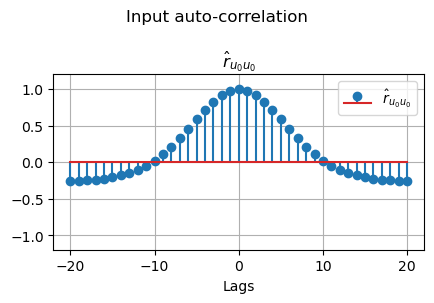

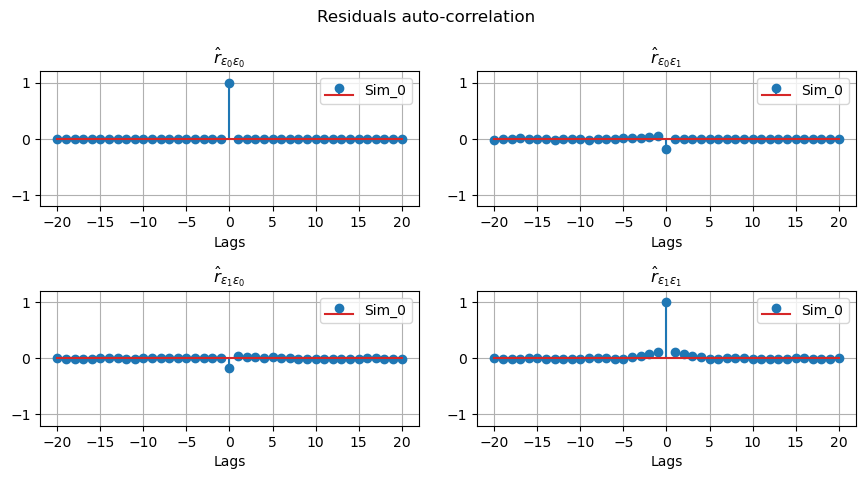

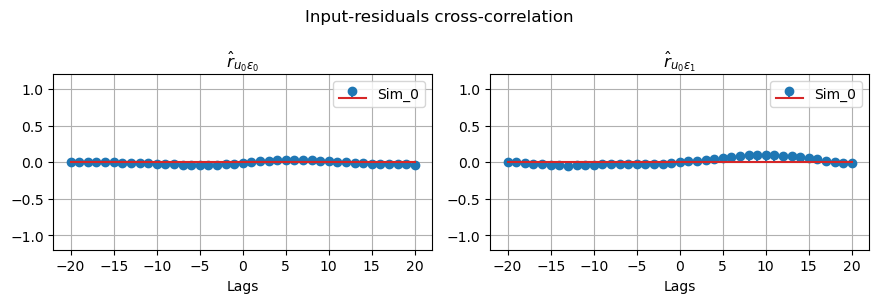

In [21]:
fig1, fig2, fig3 = vs.plot_residuals()
display(fig1)
display(fig2)
display(fig3)

Dymoval simply computes some statistics of the above functions to estimate their whiteness. By default, Dymoval compute the mean of the absolute values of each ACF sample (abs_mean), but you can choose other statistic types like quadratic, mean, max, etc. Regardless of your choice, for each plot, you get a number.

Given that most of the times we deal with MIMO systems, the result of each plot is arranged in a matrix form, and the worst case (max) of such result is taken by default, thus ultimately providing an overall evaluation value which is the whiteness level that you have seen above. But again, you can pick other statistics if you want.

The lag-time is typically given by the sampling period of the signals. However, for slow varying processes two consecutive measurements are naturally correlated if the signal is over-sampled, and therefore we may have high values of the ACF, especially around lag = 0. That is, we are assessing how measurements are auto-correlated and not how the signal is auto-correlated. This effect could jeopardize the validation results for the worst. For this reason, we should somehow downsample the signal so that two consecutive measurements are enoughly spaced each other. In this case we would be studying the actual signal behavior. And this is why several functions require passing signals bandwidths. Dymoval tries to correlate a signal with a delayed version of itsels for different lags, where the lag time interval is equal to *lag_time = 1/(2\*bandwidth)*. 

However, note that you low-pass filter a signal at a certain cutoff frequency, does not imply that the bandwith of the resulting signal has a bandwidth equal to the chosen cutoff frequency, especially if the filter order is very small. It is always good to perform an analytic or a numerical computation of a signal bandwitdh to confirm its actual estimate.

Another thing to take into consideration is that trimming your dataset could affect also the AFC. You can test it by yourself. :) 

## Handling of the input signal

Particular care must be taken for the input signal. Here are some guidelines:

- Input signal must be as clean as possible. For example, if you have three sensors available for logging measurements, use the best sensor for logging the input signal.
- Run experiments by attempting to hit every corner of your system. This means that input signal shall vary "as randomly as possible and in an uncorrelated way". You are going to have lot of fun in the lab running your system in this way. :)
- Sometimes it is not possible to run "crazy" tests on the system. For example, if you are developing a space shuttle, I don't think you will ever have any approval for running it on random routes in the sky. In these case, we have to accept it and we can neglect the input from our validation procedure. You can either set a value larger than 1.0 in the input whiteness threshold, or you can pass the argument `ignore_input=True` to the `validate_models()` function.

## Further adjustments

If the residuals are bad, it does not necessarily mean that your model is bad. It could simply mean that your validation procedure is not good. 

You may have high AFC values because the input signal has some trends or means or offsets, etc that shall be accommodated. In that case, consider to further maniplate your input signal e.g. by detrending it, by removing means, offsets, etc. for the validation procedure (but not for feeding your model!).  

Note that you don't have to do the same manipulationn for the output signals because what you are looking in the residuals analysis are the *residuals* values and not the *output* values. By definintion, the residuals take the difference between the measured and the simulated outputs and therefore eventual trends in the outputs are automatically canceled. If your `ValidationSession` object dataset has a e.g. detrended input, then the internal Dymoval machinery will use such a detrended input with a (naturally) detrended residuals for computing the various statistics, which is a correct approach. 

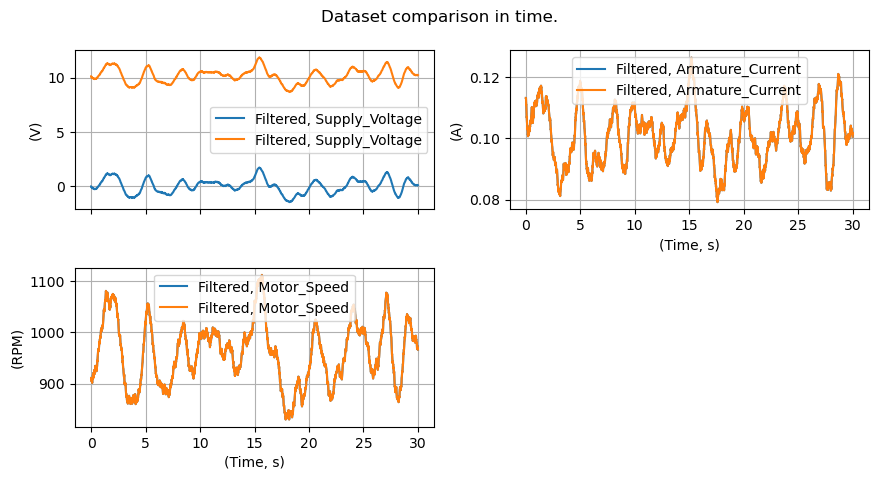

In [40]:
ds_filt_adjusted = ds_filt.remove_means('Supply_Voltage')
dmv.compare_datasets(ds_filt_adjusted, ds_filt)

From the plot, we can see that the input signal has some sort of peridicity, which means that it is most likely correlated with a delayed version of itself. This justify the scarse whiteness reported of about 0.3. 

Let's build a `ValidationSession` object with this new dataset, and let's append the simulation results `y_sim` computed before.

In [44]:
vs_adjusted = dmv.ValidationSession('vs adjusted', ds_filt_adjusted,U_bandwidths=cutoff, Y_bandwidths=[cutoff, cutoff])
vs_adjusted = vs_adjusted.append_simulation('Model 1', y_names=['Current', 'Speed'], y_data=y_sim)
vs_adjusted_trimmed = vs_adjusted.trim(1, 30)
vs_adjusted_trimmed

Validation session name: vs adjusted

Validation setup:
----------------
Inputs auto-correlation
Statistic: abs_mean-max
local weights: None
global weights: None
num lags: 41

Residuals auto-correlation:
Statistic: abs_mean-max
local weights: None
global weights: None
num lags: 41

Input-residuals cross-correlation:
Statistic: abs_mean-max
local weights: None
global weights: None
num lags: 41

Validation results:
-------------------
Thresholds: 
Input whiteness (abs_mean-max): 0.6 
R-Squared (%): 35.0000 
Residuals whiteness (abs_mean-max): 0.5000 
Input-Res whiteness (abs_mean-max): 0.5000 
Actuals:
                                    Model 1
Input whiteness (abs_mean-max)       0.3532
R-Squared (%)                       65.9009
Residuals whiteness (abs_mean-max)   0.1062
Input-Res whiteness (abs_mean-max)   0.1886

         Model 1  
Outcome: PASS     

The input whiteness didn't change at all, nor the other metrics who are independent of such an input adjustment such as the R-squared and the residuals auto-correlation, but we get a better value for the input-residuals whiteness.

However, keep in mind that you must feed your models with the non-detrended/removed_mean/etc. input. That is, you shall consider the input that is as close as possible to the one used in the lab when you are generating simulated outputs. Only after that you can further manipulate your input for the sole purpose of computing its actual whiteness and the input-residuals whiteness.

The message here is that pay attention that you are not "mixing apples with oranges".


## Final remarks

Dymoval is build to simplify common tasks that an engineer has to carry out and who may find tools such as pandas, matplotlib, numpy, etc. a bit too overwhelming.
However, if you need more power, consider that

1. Every plot returns a *matplotlib* figure, which means that you can further manipulate such a figure through the *matplotlib* API.
2. If you need to do further manipulate youd dataset and *dymoval* won't provide you certain functionalities, the you can use the method `dump_to_signals()` to dump the all the signals stored in the `Dataset` instance into a list of `Signals`. At this point you could use any packages you want (e.g. *numpy*, *scipy*, etc.) to manipulate the signals and then you may want to instantiate a brand new `Dataset` object from the manipulated signals.  


#### Another note
When manipulating `Dataset` or `ValidationSession` object, Dymoval won't change the current instance, but it returns a modified copy of it.
This means that e.g. `ds.remove_means()` won't change `ds` but you should explicitely re-assign it, e.g. `ds = ds.remove_means()`.



## What's next?

Feel free to check the [documentation](https://ubaldot.github.io/dymoval/) to have access to the full API and to get more insight on how *dymoval* is structured.

Good luck!

# Credits
Picture from Mika Baumeister on Unsplash.